In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from __future__ import print_function

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

# Implementing new kernels

This notebook was made with the following version of george:

In [2]:
import george
george.__version__

'1.0.0.dev0'

All the kernels used by george must be implemented in C++ with Python bindings. This means that you need to recompile the code anytime you want to add a new kernel. This is an unavoidable PITA but—as of version 1.0—george comes with a kernel specification language that is designed to make this process as painless as possible.

To follow this tutorial, you'll need the development version of george. You should [follow the instructions here](../quickstart/) to get that set up and once you can build the code, let's start implementing a new kernel.


## The kernel function

In this tutorial, we will work through the implementation of a kernel that wasn't available in early versions of the code: the `LocalGaussianKernel`. This kernel has been used by [Ian Czekala](http://iancze.github.io) in his stellar spectrum fitting algorithm [Starfish](http://iancze.github.io/Starfish/).

This kernel is not stationary and its value is given by the following equation:

$$k(x_i,\,x_j) = \exp \left(
-\frac{(x_i - x_0)^2 + (x_j - x_0)^2}{2\,w}
\right)$$

where the parameters $x_0$ and $w$ are the location and width of the Gaussian respectively. We're actually going to parameterize this kernel using $\ln w$ instead of $w$ because it must be strictly positive.

In our implementation, we'll also need the derivatives of this function with respect to the hyperparameters so let's list those now:

$$\frac{\mathrm{d}k(x_i,\,x_j)}{\mathrm{d}x_0} = \exp \left(
-\frac{(x_i - x_0)^2 + (x_j - x_0)^2}{2\,w}
\right) \, \frac{x_i + x_j - 2\,x_0}{w}$$

and

$$\frac{\mathrm{d}k(x_i,\,x_j)}{\mathrm{d}\ln w} = \exp \left(
-\frac{(x_i - x_0)^2 + (x_j - x_0)^2}{2\,w}
\right) \, \frac{(x_i - x_0)^2 + (x_j - x_0)^2}{2\,w} \quad.$$


## Kernel specification

In the root directory of your development version of george, there should be a directory called `kernels`. In this directory, create a new file called `MyLocalGaussian.yml` and edit it to have the following contents:

```
name: MyLocalGaussianKernel
doc: You should always document your code.
stationary: false
params: [x0, log_w]

reparams:
    inv_2w: return 0.5 * exp(-log_w);

value: |
    double d1 = x1 - x0, d2 = x2 - x0;
    return exp(-(d1*d1 + d2*d2) * inv_2w);

grad:
    x0: |
        double d1 = x1 - x0, d2 = x2 - x0;
        return 2 * exp(-(d1*d1 + d2*d2) * inv_2w) * inv_2w * (d1 + d2);
    log_w: |
        double d1 = x1 - x0, d2 = x2 - x0,
               arg = (d1*d1 + d2*d2) * inv_2w;
        return exp(-arg) * arg;
```

This file is written in a markup language called YAML and there are a lot of online resources for the details of the syntax but let's go through it line-by-line now to explain what's going on.

1. The `name` field is the name that you want the Python class to have. The convention is to have it end in `Kernel` but I guess you can call it more-or-less anything.

2. The `doc` field let's you write a docstring for the class. This is always a good idea and you can look at the existing kernels for inspiration.

3. This kernel is not stationary and you specify that using the `stationary` field.

4. `params` lists the "natural" parameters of the kernel. The derivatives should be computed with respect to these parameters.

5. It is often useful (for speed) to pre-compute a reparameterized form of the parameters. In this case, we don't want to make too many calls to the `exp` function so we'll pre-compute $(2\,w)^{-1}$. To do this, we add an entry to the `reparams` dictionary with raw C++ code for a function that returns the reparameterization. This function will take the natural parameters as input so you can use them directly by name.

6. The `value` entry gives the raw C++ code for evaluating the kernel function at input `double`s `x1` and `x2`. This function will take the parameters and the reparameterizations as inputs so you can use them by name.

7. Finally, the `grad` dictionary gives the raw C++ code for computing the gradient as a function of each parameter.

After you save this file and recompile george, you should now have access to this kernel as follows:

In [4]:
import numpy as np
from george import kernels

kernel = 5 * kernels.MyLocalGaussianKernel(x0=0.0, log_w=np.log(0.2))
kernel += 5 * kernels.Matern32Kernel(100.0)

Whenever you implement a new kernel, you should numerically test that you've implemented the gradients correctly. The `Kernel` implementation includes a function for doing exactly that and here's how you would call it:

In [5]:
x = np.linspace(-10, 10, 500)
kernel.test_gradient(np.atleast_2d(x).T)

If our implementation was wrong, this would have raised an exception so this looks pretty promising!

Now, we can plot the covariance matrix given by this kernel as follows:

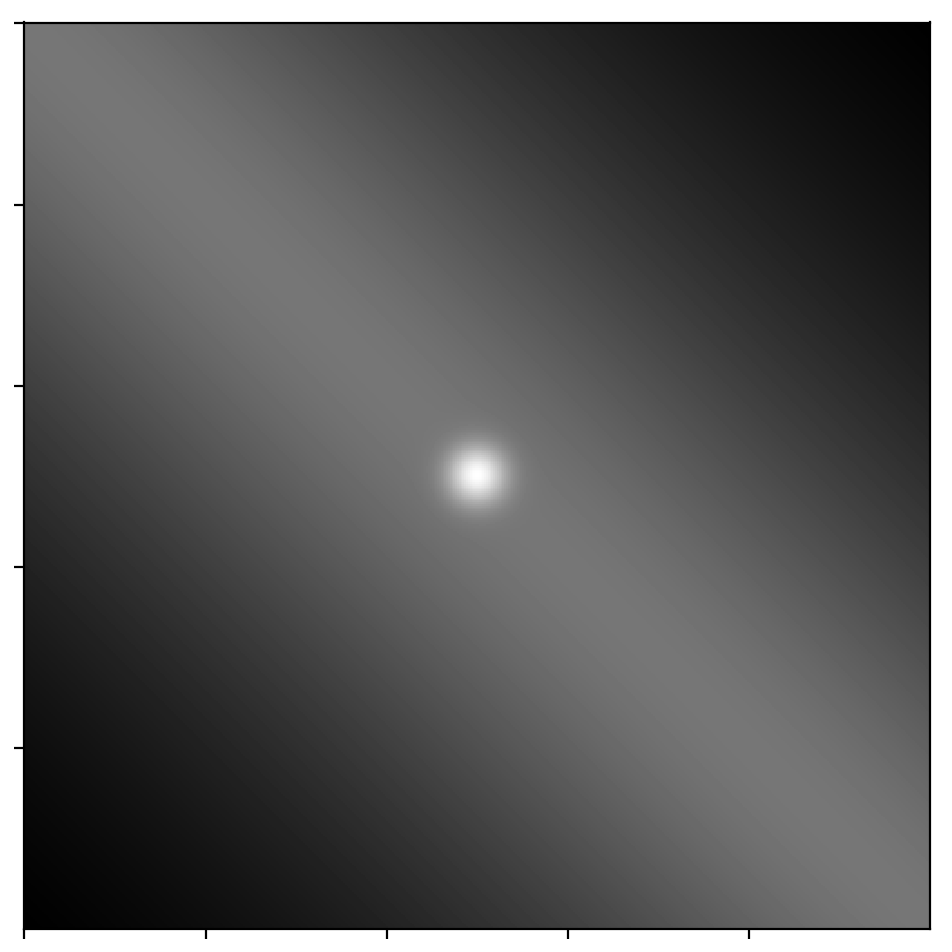

In [6]:
import matplotlib.pyplot as pl

k = kernel.get_value(np.atleast_2d(x).T)
pl.figure(figsize=(6, 6))
pl.imshow(k, cmap="gray", interpolation="nearest")
pl.gca().set_xticklabels([])
pl.gca().set_yticklabels([]);

From this covariance function, we can sample some representative functions:

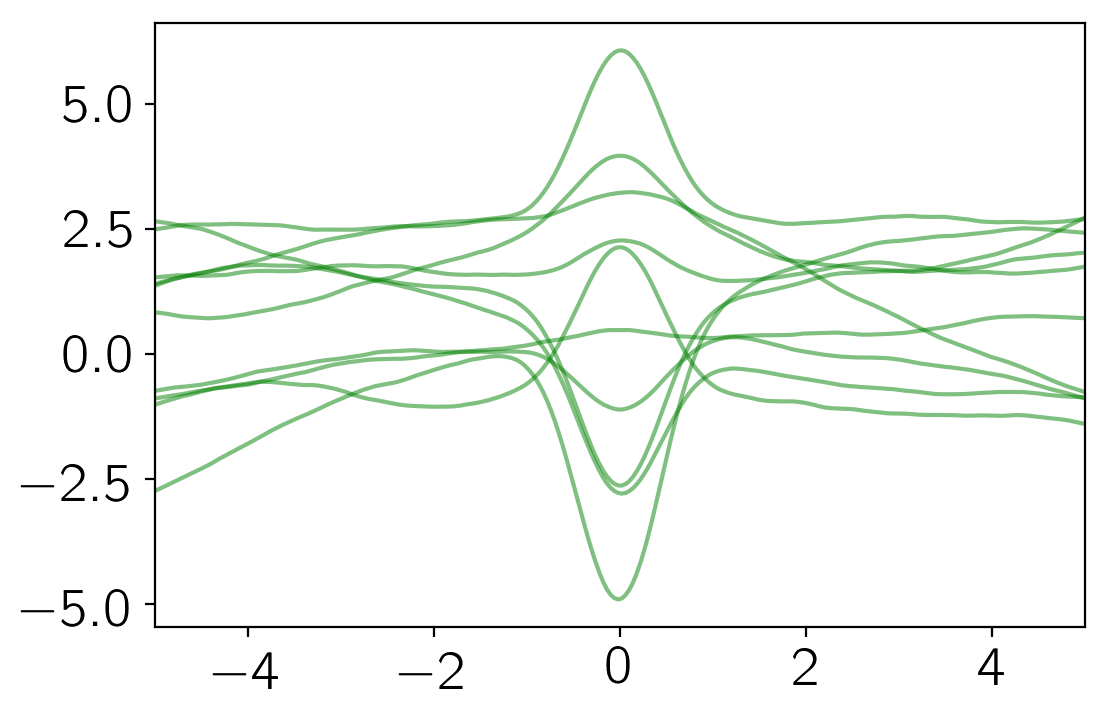

In [9]:
np.random.seed(123)
gp = george.GP(kernel)
gp.compute(x)
y = gp.sample(size=10)

pl.plot(x, y.T, "g", lw=1.5, alpha=0.5)
pl.xlim(-5, 5);

George already includes an implementation of this kernel (called the `LocalGaussianKernel`) so we'll finish here but when you implement your own favorite kernel, you should now open a pull request to include the kernel in the released version of george.